# Country model analysis

Analysis of the `uniform_summary.csv` dataset based on _dendrogram and heat map_ visulization, then comparison of different clustering methods, based on the tutorials:

  * <https://python-graph-gallery.com/404-dendrogram-with-heat-map/>
  * <https://seaborn.pydata.org/generated/seaborn.clustermap.html>
  * <https://www.geeksforgeeks.org/hierarchically-clustered-heatmap-in-python-with-seaborn-clustermap/>
  * <https://scikit-learn.org/stable/modules/clustering.html>

## set up environment

Load the library dependencies

In [1]:
from collections import defaultdict
from icecream import ic
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
import scipy
import warnings
import watermark

Filter the less useful warnings

In [2]:
warnings.filterwarnings("ignore")

Show a watermark of the OS, hardware, language environment, and dependent library versions.

In [3]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-01-13T17:31:58.607431-08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

scipy     : 1.15.1
seaborn   : 0.13.2
pandas    : 2.2.3
pycountry : 24.6.1
numpy     : 2.2.1
matplotlib: 3.10.0
watermark : 2.5.0



## data prep

Load the `uniform` dataset, which is a subset of up to 1k addresses from each country, where that many exist.

In [4]:
file_path: str = "data/uniform_summary.csv"
df: pd.DataFrame = pd.read_csv(file_path)
df = df.set_index("country")
df.head()

,expected model,% correct,count correct,count wrong,['ad'],['ae'],['af'],['ag'],['ai'],['al'],...,['vn'],['vu'],['wf'],['ws'],['xk'],['ye'],['yt'],['za'],['zm'],['zw']
country,,,,,,,,,,,,,,,,,,,,,
tw,['tw'],0.263,263,737,0.0,0.000,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
jp,['jp'],0.880,880,120,0.0,0.000,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
kr,['kr'],0.989,989,11,0.0,0.000,0.0,0.0,0.000,0.0,...,0.001,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
cn,['cn'],0.934,934,66,0.0,0.000,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
us,['us'],0.807,807,193,0.0,0.001,0.0,0.0,0.002,0.0,...,0.000,0.0,0.0,0.001,0.0,0.0,0.0,0.012,0.001,0.002


Drop all columns except for independent and dependent variables

In [5]:
df = df.drop(df.columns[[0, 1, 2, 3]], axis = 1)
df.head()

,['ad'],['ae'],['af'],['ag'],['ai'],['al'],['am'],['ao'],['ar'],['as'],...,['vn'],['vu'],['wf'],['ws'],['xk'],['ye'],['yt'],['za'],['zm'],['zw']
country,,,,,,,,,,,,,,,,,,,,,
tw,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
jp,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
kr,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.001,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
cn,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
us,0.0,0.001,0.0,0.0,0.002,0.0,0.0,0.0,0.001,0.0,...,0.000,0.0,0.0,0.001,0.0,0.0,0.0,0.012,0.001,0.002


Clean the column names, expanding the full country names based on ISO 3166

In [6]:
def map_cc_name (
    country: str,
    ) -> str:
    """
    Map from a country code to its expanded name based on ISO 3166
    """
    try:
        if pycountry.countries.lookup(country):
            name = pycountry.countries.get(alpha_2=country).name
            return f"{ country } - { name }"
    except:
        return f"{ country } ???"


col_names: list = [
    map_cc_name((name.strip()[2:])[:2])
    for name in df.columns.values.tolist()
]    

df.columns = col_names
df.head()

,ad - Andorra,ae - United Arab Emirates,af - Afghanistan,ag - Antigua and Barbuda,ai - Anguilla,al - Albania,am - Armenia,ao - Angola,ar - Argentina,as - American Samoa,...,vn - Viet Nam,vu - Vanuatu,wf - Wallis and Futuna,ws - Samoa,xk ???,ye - Yemen,yt - Mayotte,za - South Africa,zm - Zambia,zw - Zimbabwe
country,,,,,,,,,,,,,,,,,,,,,
tw,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
jp,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
kr,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.001,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
cn,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.000
us,0.0,0.001,0.0,0.0,0.002,0.0,0.0,0.0,0.001,0.0,...,0.000,0.0,0.0,0.001,0.0,0.0,0.0,0.012,0.001,0.002


Create a scaled, normalized view of the data where each variable has mean of `0` and standard dev of `1`, as input formatted for the `scikit-learn` clustering algorithms.

In [7]:
from sklearn.preprocessing import StandardScaler

scaled_data: np.ndarray = StandardScaler().fit_transform(df)

## interactive visualization

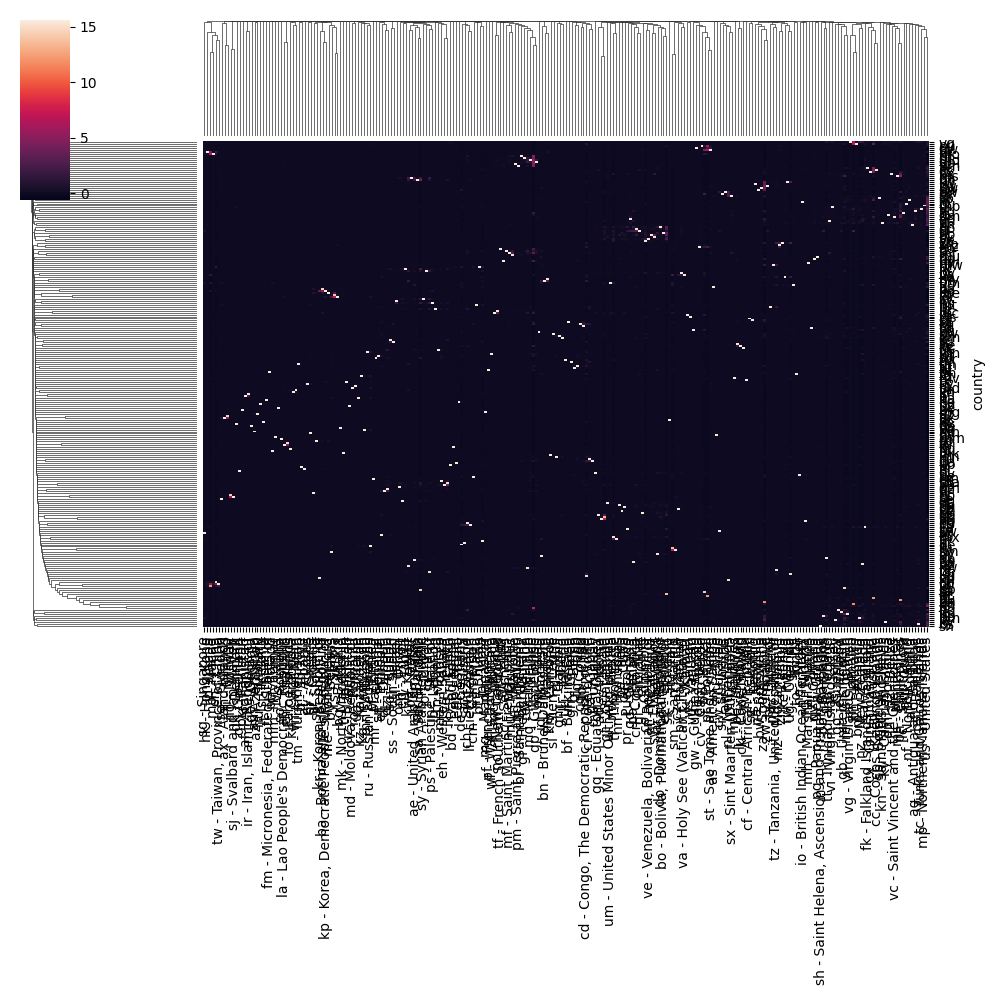

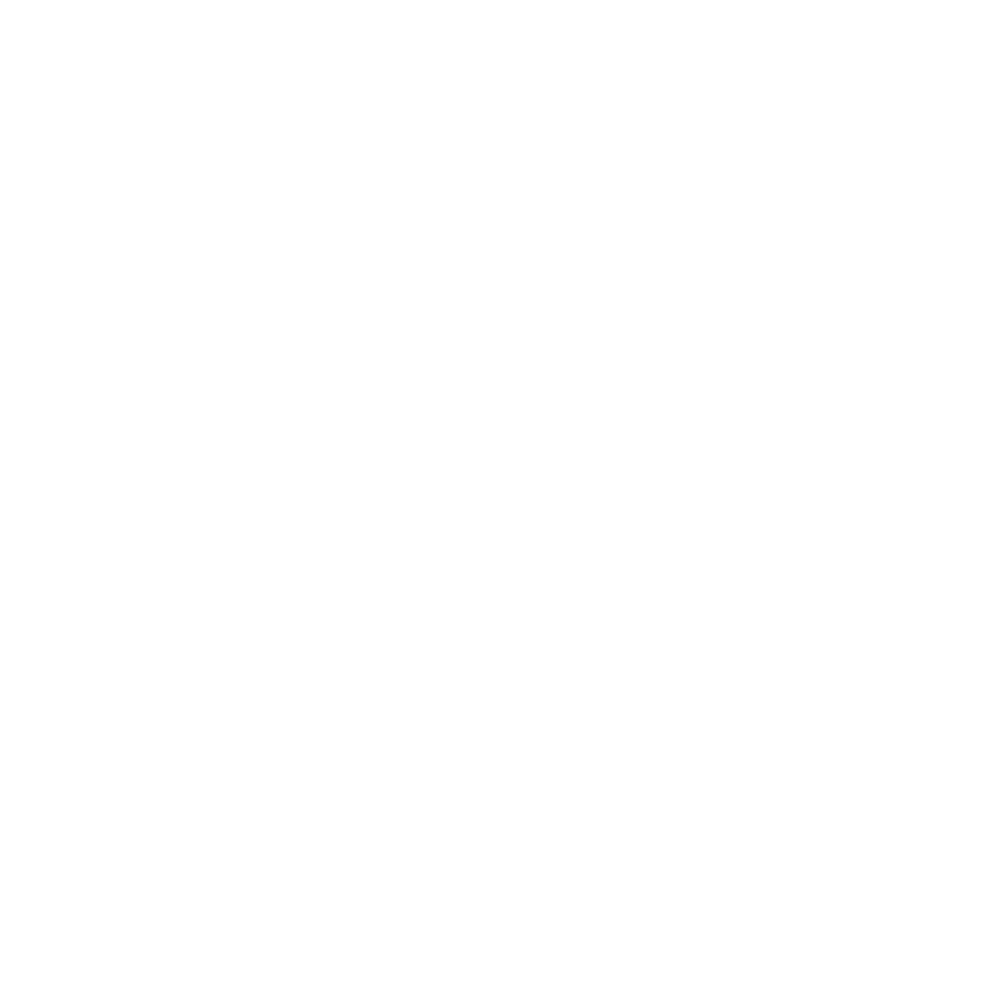

In [8]:
%matplotlib ipympl

plt.figure(figsize = (10, 10,))

sns_plot: sns.matrix.ClusterGrid = sns.clustermap(
    df,
    method = "average",
    #standard_scale = 1,
    z_score = 1,
    xticklabels = True,
    yticklabels = True,
)

plt.tick_params(axis = "x", which = "both", rotation = 0)
plt.savefig("cluster.png")
plt.show()

## K-means clustering

In [9]:
from sklearn.cluster import KMeans

# instantiate the k-means class, specifying an optimal number of clusters
K: int = 10

kmeans = KMeans(
    init = "random",
    n_clusters = K,
    n_init = 10,
    random_state = 1,
)

# fit k-means algorithm to data and set cluster assignment in a dataframe

kmeans.fit(scaled_data)
predicted: list = kmeans.labels_

In [10]:
df2 = df.copy(deep = True)
df2["cluster"] = predicted

clusters: dict = defaultdict(set)

for index, row in df2.iterrows():
    clust_id: int = int(row["cluster"])
    clusters[clust_id].add(index)

In [11]:
for key, val in clusters.items():
    print(key, len(val))

    for country in val:
        print("", map_cc_name(country))

1 180
 gy - Guyana
 ir - Iran, Islamic Republic of
 km - Comoros
 kg - Kyrgyzstan
 li - Liechtenstein
 kr - Korea, Republic of
 dj - Djibouti
 hk - Hong Kong
 cc - Cocos (Keeling) Islands
 az - Azerbaijan
 mc - Monaco
 lr - Liberia
 pg - Papua New Guinea
 bj - Benin
 gq - Equatorial Guinea
 st - Sao Tome and Principe
 cn - China
 sz - Eswatini
 bf - Burkina Faso
 ca - Canada
 ru - Russian Federation
 iq - Iraq
 ht - Haiti
 mt - Malta
 tw - Taiwan, Province of China
 tr - Türkiye
 cz - Czechia
 tn - Tunisia
 fk - Falkland Islands (Malvinas)
 mw - Malawi
 tj - Tajikistan
 af - Afghanistan
 vi - Virgin Islands, U.S.
 dz - Algeria
 sn - Senegal
 gb - United Kingdom
 vu - Vanuatu
 mo - Macao
 sl - Sierra Leone
 so - Somalia
 hr - Croatia
 pl - Poland
 bh - Bahrain
 bw - Botswana
 sg - Singapore
 au - Australia
 tz - Tanzania, United Republic of
 kw - Kuwait
 il - Israel
 je - Jersey
 mz - Mozambique
 aw - Aruba
 ax - Åland Islands
 gt - Guatemala
 sm - San Marino
 at - Austria
 cm - Cameroo

**Analysis:**

K-means works reasonably well for distinguishing among the smaller groupings, although it's not particularly effective working from the full `uniform` dataset down into groups.

## Hierarchical clustering

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Perform agglomerative clustering
agg_clustering = AgglomerativeClustering(n_clusters = 4)
predicted: list = agg_clustering.fit_predict(scaled_data)

predicted

array([2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3,
       0, 0, 1, 3, 1, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0])

In [13]:
df2 = df.copy(deep = True)
df2["cluster"] = predicted

clusters: dict = defaultdict(set)

for index, row in df2.iterrows():
    clust_id: int = int(row["cluster"])
    clusters[clust_id].add(index)

In [14]:
for key, val in clusters.items():
    print(key, len(val))

    for country in val:
        print("", map_cc_name(country))

2 5
 tw - Taiwan, Province of China
 cn - China
 hk - Hong Kong
 mo - Macao
 jp - Japan
0 183
 ir - Iran, Islamic Republic of
 hn - Honduras
 km - Comoros
 kg - Kyrgyzstan
 li - Liechtenstein
 kr - Korea, Republic of
 dj - Djibouti
 az - Azerbaijan
 mc - Monaco
 lr - Liberia
 bj - Benin
 gq - Equatorial Guinea
 st - Sao Tome and Principe
 sv - El Salvador
 sz - Eswatini
 bf - Burkina Faso
 ru - Russian Federation
 na - Namibia
 iq - Iraq
 mt - Malta
 tr - Türkiye
 cz - Czechia
 tn - Tunisia
 mw - Malawi
 sd - Sudan
 tj - Tajikistan
 pr - Puerto Rico
 af - Afghanistan
 ni - Nicaragua
 dz - Algeria
 sn - Senegal
 vu - Vanuatu
 co - Colombia
 so - Somalia
 hr - Croatia
 pl - Poland
 bh - Bahrain
 bw - Botswana
 sg - Singapore
 pe - Peru
 tz - Tanzania, United Republic of
 do - Dominican Republic
 kw - Kuwait
 il - Israel
 pa - Panama
 mz - Mozambique
 aw - Aruba
 ax - Åland Islands
 gt - Guatemala
 uy - Uruguay
 sm - San Marino
 at - Austria
 cm - Cameroon
 va - Holy See (Vatican City Sta

**Analysis:**

Hierarchical clustering could likely work well if we approached this "recursively", that is by redacting the smaller groupings from the top level, then repeating the analysis. For example in the report above, the `{ Taiwan, Macao, China, Japan, Hong Kong }` cluster could be redacted at the first iteration.